In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [4]:
cell_img = cv2.imread('cells3.jpg')

In [423]:
#Kernel and sigma list for experimentation
kernel_sizes=[(251,251)]
sigmas=[91]

In [302]:
cell_low_pass_filter_list=[]
def get_conv_filter(filter_type,kernels,standard_deviations,image):
    filter_list=[]
    if filter_type == "Gauss":
        for kernel in kernels:
            for sigma in standard_deviations:
                gauss_smooth_image=cv2.GaussianBlur(image,kernel,sigma)
                filter_list.append(gauss_smooth_image)
        return filter_list

In [6]:
def normalize_image(manipulated_image):
   
    min_val = np.min(manipulated_image)
    max_val = np.max(manipulated_image)

    normalized_image = (manipulated_image - min_val) / (max_val - min_val)

    normalized_image = np.clip(normalized_image, 0, 1)

    normalized_image_uint8 = (normalized_image * 255).astype(np.uint8)

    return normalized_image_uint8

In [292]:
def compute_color_tensors(derivatives):
    tensor_size = len(derivatives["red"])
    tensor_structure = np.zeros((tensor_size, tensor_size), dtype=object)
    
    for i in range(tensor_size):
        for j in range(tensor_size):
            tensor_product = np.zeros_like(derivatives["red"][0])  # Initialize tensor product
            
            # Iterate over each derivative and compute the tensor product
            for key in derivatives.keys():
                derivative_i = derivatives[key][i]
                derivative_j = derivatives[key][j]
                tensor_product += np.multiply(derivative_i, derivative_j)
            
            # Apply filter and normalization
            filter_list = get_conv_filter("Gauss", kernel_sizes, sigmas, tensor_product)
            tensor_structure[i, j] = np.multiply(np.array(filter_list[0]), tensor_product)
            tensor_structure[i, j] = normalize_image(tensor_structure[i, j])
    
    return tensor_structure

In [428]:
derivatives={}
# Split the image into its RGB channels
b, g, r = cv2.split(cell_img)

# Compute derivatives along each channel
Ix_b = cv2.Sobel(b, cv2.CV_64F, 1, 0, ksize=3)  
Iy_b = cv2.Sobel(b, cv2.CV_64F, 0, 1, ksize=3) 

Ix_g = cv2.Sobel(g, cv2.CV_64F, 1, 0, ksize=3)  
Iy_g = cv2.Sobel(g, cv2.CV_64F, 0, 1, ksize=3)  

Ix_r = cv2.Sobel(r, cv2.CV_64F, 1, 0, ksize=3)  
Iy_r = cv2.Sobel(r, cv2.CV_64F, 0, 1, ksize=3)  

derivatives["red"] = [Ix_r, Iy_r]
derivatives["green"] = [Ix_g, Iy_g]
derivatives["blue"] = [Ix_b, Iy_b]

Ix=cv2.merge((Ix_b,Ix_g,Ix_r))
Ix=normalize_image(Ix)

Iy=cv2.merge((Iy_b,Iy_g,Iy_r))
Iy=normalize_image(Iy)

Ix_b=normalize_image(Ix_b)
Iy_b=normalize_image(Iy_b)

Ix_g=normalize_image(Ix_g)
Iy_g=normalize_image(Iy_g)

Ix_r=normalize_image(Ix_r)
Iy_r=normalize_image(Iy_r)


tensor_structure=compute_color_tensors(derivatives)

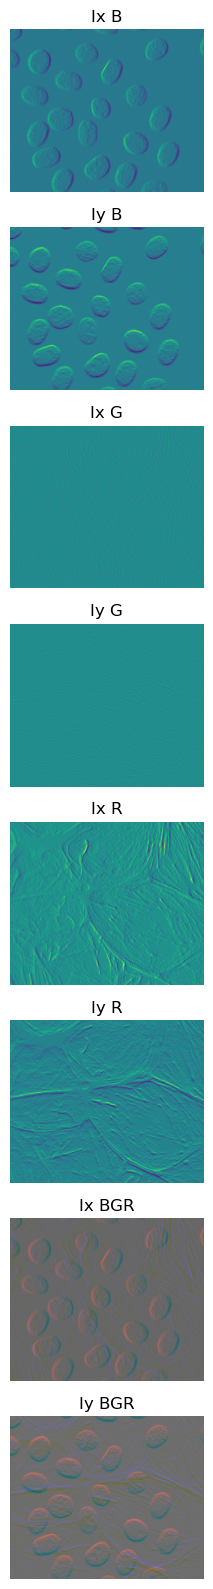

In [424]:
images = [Ix_b, Iy_b, Ix_g, Iy_g, Ix_r, Iy_r, Ix, Iy]
titles = ['Ix B', 'Iy B', 'Ix G', 'Iy G', 'Ix R', 'Iy R', 'Ix BGR', 'Iy BGR']

# Plotting
fig, axes = plt.subplots(8, 1, figsize=(8, 16))

for i, (image, title) in enumerate(zip(images, titles)):
    axes[i].imshow(image)
    axes[i].set_title(title)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

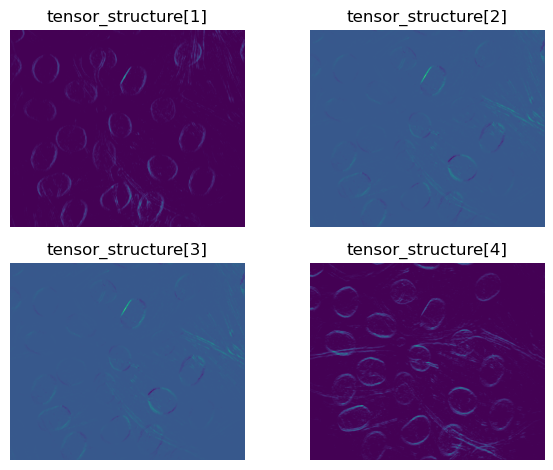

In [429]:
fig, axes = plt.subplots(2,2)
for ax in axes.flat:
    ax.set_axis_off()
plt.subplot(221), plt.imshow(tensor_structure[0,0]), plt.title('tensor_structure[1]')
plt.subplot(222), plt.imshow(tensor_structure[0,1]), plt.title('tensor_structure[2]')
plt.subplot(223), plt.imshow(tensor_structure[1,0]), plt.title('tensor_structure[3]')
plt.subplot(224), plt.imshow(tensor_structure[1,1]), plt.title('tensor_structure[4]')
plt.tight_layout() 

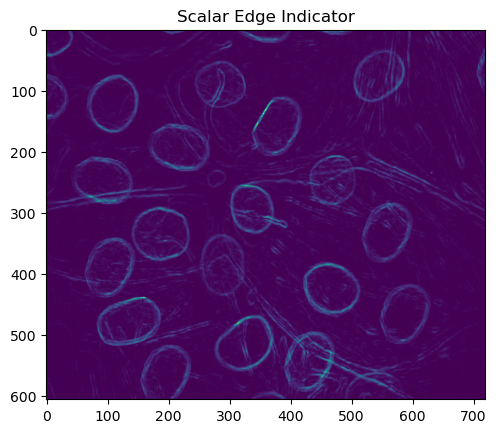

In [430]:
def calculate_scalar_edge(tensor_structure):
    scalar_edge_indicator=np.sum(np.diagonal(tensor_structure))
    fig, axes = plt.subplots(1,1)
    ax.set_axis_off()
    plt.subplot(111), plt.imshow(scalar_edge_indicator), plt.title('Scalar Edge Indicator')
    
calculate_scalar_edge(tensor_structure)

(<Axes: title={'center': 'Iy_gray'}>,
 Text(0.5, 1.0, 'Iy_gray'))

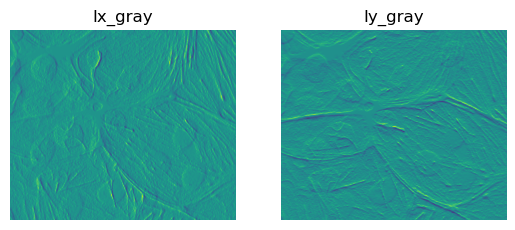

In [8]:
cell_gray_image = cv2.cvtColor(cell_img, cv2.COLOR_BGR2GRAY)

Ix_gray = cv2.Sobel(cell_gray_image, cv2.CV_64F, 1, 0, ksize=3)
Ix_gray=normalize_image(Ix_gray)

Iy_gray = cv2.Sobel(cell_gray_image, cv2.CV_64F, 0, 1, ksize=3) 
Iy_gray=normalize_image(Iy_gray)

fig, axes = plt.subplots(1,2)
for ax in axes.flat:
    ax.set_axis_off()
plt.subplot(121), plt.imshow(Ix_gray), plt.title('Ix_gray')
plt.subplot(122), plt.imshow(Iy_gray), plt.title('Iy_gray')


(<Axes: title={'center': 'Gradient Magnitude'}>,
 Text(0.5, 1.0, 'Gradient Magnitude'))

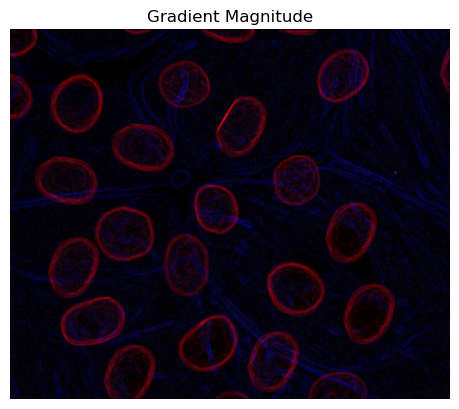

In [432]:
gradient_magnitude = np.sqrt((Ix1**2)+(Iy1**2))
gradient_magnitude=normalize_image(gradient_magnitude)

fig, ax = plt.subplots(1,1)
ax.set_axis_off()
plt.subplot(111), plt.imshow(gradient_magnitude), plt.title('Gradient Magnitude')
